In [2]:
import numpy as np
import pandas as pd
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise  import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

In [3]:
for dirname, _, filenames in os.walk('.../amazon-product-reviews'):
    for filename in filenames:
        print(os.path.join(dirname,filename))
        
        

C:/Users/Apurva/Desktop/amazon-product-reviews\ratings_Electronics (1).csv


In [4]:
electronics_data=pd.read_csv('C:/Users/Apurva/Desktop/amazon-product-reviews/ratings_Electronics (1).csv', names=['userId','productId','Rating','timestamp'])

In [5]:
electronics_data.head()

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [6]:
electronics_data.shape

(7824482, 4)

In [7]:
electronics_data=electronics_data.iloc[:1048576,0:]

In [8]:
electronics_data.dtypes

userId        object
productId     object
Rating       float64
timestamp      int64
dtype: object

In [9]:
electronics_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048576 entries, 0 to 1048575
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   userId     1048576 non-null  object 
 1   productId  1048576 non-null  object 
 2   Rating     1048576 non-null  float64
 3   timestamp  1048576 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 32.0+ MB


In [10]:
electronics_data.describe()['Rating'].T

count    1.048576e+06
mean     3.973380e+00
std      1.399329e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

In [11]:
print('Minimum rating is %d' %(electronics_data.Rating.min()))
print('Maximum rating is %d' %(electronics_data.Rating.max()))

Minimum rating is 1
Maximum rating is 5


In [12]:
print('Number of missing values across columns: \n',electronics_data.isnull().sum())

Number of missing values across columns: 
 userId       0
productId    0
Rating       0
timestamp    0
dtype: int64


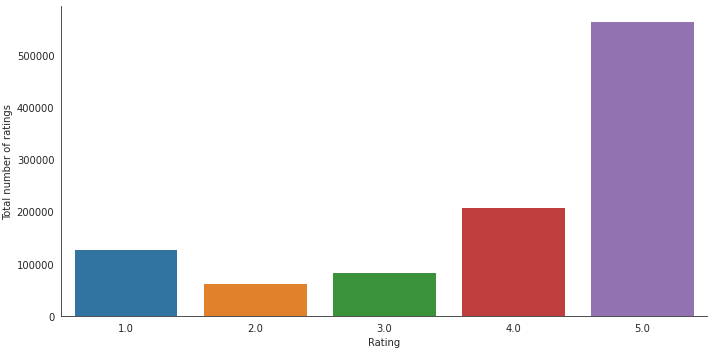

In [13]:
with sns.axes_style('white'):
    g=sns.factorplot('Rating',data=electronics_data,aspect=2.0,kind='count')
    g.set_ylabels('Total number of ratings')

In [14]:
print('Total data:')
print('Total number of ratings:',electronics_data.shape[0])
print('Total number of users:',len(np.unique(electronics_data.userId)))
print('Total number of products:',len(np.unique(electronics_data.productId)))

Total data:
Total number of ratings: 1048576
Total number of users: 786330
Total number of products: 61894


In [15]:
electronics_data.drop(['timestamp'], axis=1, inplace=True)

In [16]:
no_of_rated_products_per_user = electronics_data.groupby(by='userId')['Rating'].count().sort_values(ascending=False)
no_of_rated_products_per_user.head()

userId
A5JLAU2ARJ0BO     412
A231WM2Z2JL0U3    249
A25HBO5V8S8SEA    164
A6FIAB28IS79      146
AT6CZDCP4TRGA     128
Name: Rating, dtype: int64

In [17]:
no_of_rated_products_per_user.describe()

count    786330.000000
mean          1.333506
std           1.385612
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         412.000000
Name: Rating, dtype: float64

In [18]:
quantiles = no_of_rated_products_per_user.quantile(np.arange(0,1.01,0.01),interpolation='higher')

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'Quantiles and their values')

<AxesSubplot:title={'center':'Quantiles and their values'}>

Text(0, 0.5, 'Number of ratings by user')

Text(0.5, 0, 'Value at the quantile')

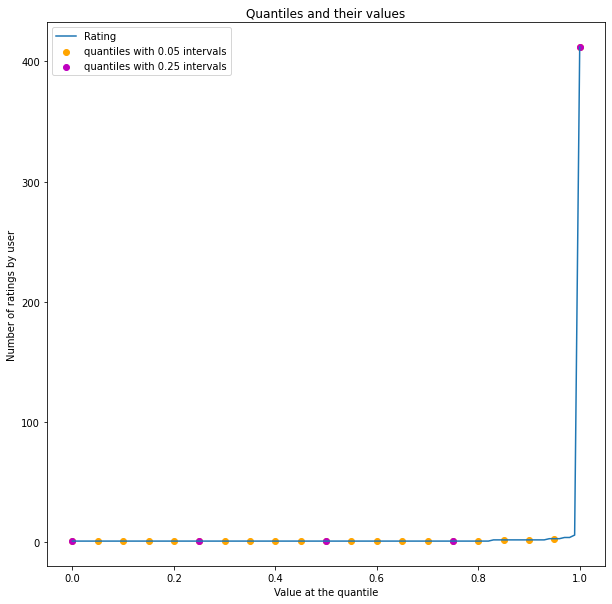

In [19]:
plt.figure(figsize=(10,10))
plt.title('Quantiles and their values')
quantiles.plot()
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label='quantiles with 0.05 intervals')
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label='quantiles with 0.25 intervals')
plt.ylabel('Number of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

In [20]:
print('\n No of rated product more than 50 per user : {}\n'.format(sum(no_of_rated_products_per_user >= 50)) )


 No of rated product more than 50 per user : 38



In [21]:
new_df = electronics_data.groupby('productId').filter(lambda x:x['Rating'].count() >= 50)

Text(0.5, 1.0, 'Ratings per product')

Text(0.5, 0, 'Product')

Text(0, 0.5, 'No of ratings per product')

[Text(-500.0, 0, ''),
 Text(0.0, 0, ''),
 Text(500.0, 0, ''),
 Text(1000.0, 0, ''),
 Text(1500.0, 0, ''),
 Text(2000.0, 0, ''),
 Text(2500.0, 0, ''),
 Text(3000.0, 0, ''),
 Text(3500.0, 0, ''),
 Text(4000.0, 0, ''),
 Text(4500.0, 0, '')]

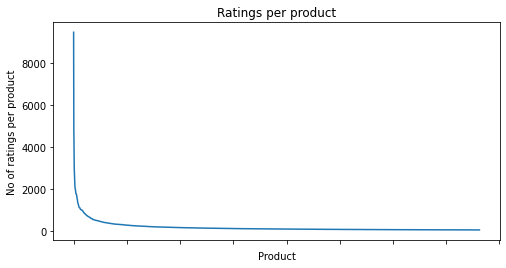

In [22]:
no_of_ratings_per_product = new_df.groupby(by='productId')['Rating'].count().sort_values(ascending=False)
fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(no_of_ratings_per_product.values)
plt.title('Ratings per product')
plt.xlabel('Product')
plt.ylabel('No of ratings per product')
ax.set_xticklabels([])
plt.show()

In [23]:
new_df.groupby('productId')['Rating'].mean().head()

productId
0972683275    4.470980
1400501466    3.560000
1400501520    4.243902
1400501776    3.884892
1400532620    3.684211
Name: Rating, dtype: float64

In [24]:
new_df.groupby('productId')['Rating'].mean().sort_values(ascending=False).head()

productId
B0000DYV9H    4.947368
B000053HC5    4.945783
B00009R96C    4.885714
B00005LE76    4.879310
B000I1X3W8    4.869565
Name: Rating, dtype: float64

In [25]:
new_df.groupby('productId')['Rating'].count().sort_values(ascending=False).head()

productId
B0002L5R78    9487
B0001FTVEK    5345
B000I68BD4    4903
B000BQ7GW8    4275
B00007E7JU    3523
Name: Rating, dtype: int64

In [26]:
ratings_mean_count = pd.DataFrame(new_df.groupby('productId')['Rating'].mean())

In [27]:
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('productId')['Rating'].count())

In [28]:
ratings_mean_count.head()

,Rating,rating_counts
productId,,
0972683275,4.470980,1051
1400501466,3.560000,250
1400501520,4.243902,82
1400501776,3.884892,139
1400532620,3.684211,171


In [29]:
ratings_mean_count.max()

Rating              4.947368
rating_counts    9487.000000
dtype: float64

<Figure size 576x432 with 0 Axes>

<AxesSubplot:>

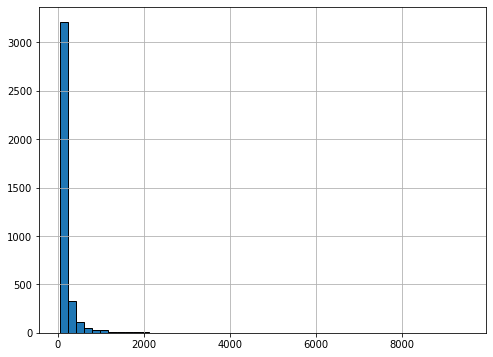

In [30]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['rating_counts'].hist(bins=50)

<Figure size 576x432 with 0 Axes>

<AxesSubplot:>

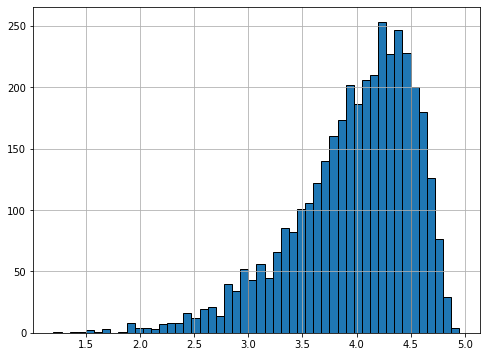

In [31]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['Rating'].hist(bins=50)

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

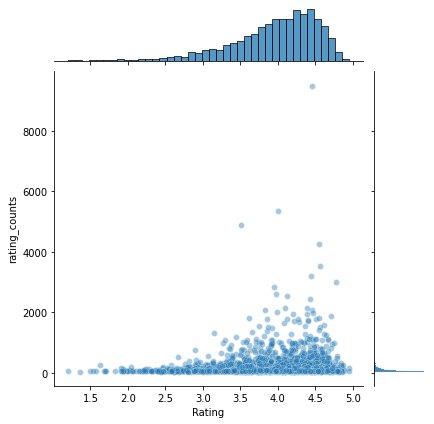

In [32]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='Rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)

<AxesSubplot:xlabel='productId'>

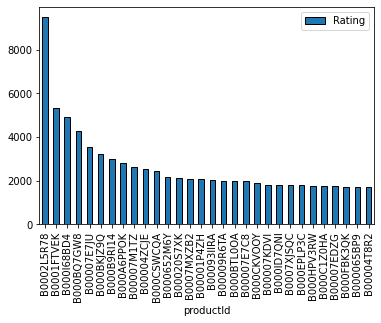

In [33]:
popular_products = pd.DataFrame(new_df.groupby('productId')['Rating'].count())
most_popular = popular_products.sort_values('Rating',ascending=False)
most_popular.head(30).plot(kind='bar')

In [34]:
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split

In [35]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(new_df,reader)

In [36]:
trainset, testset = train_test_split(data, test_size=0.3, random_state=10)

In [37]:
algo = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})

In [38]:
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [39]:
testpred = algo.test(testset)

In [40]:
testpred

[Prediction(uid='A2CTXDLXKOHCEH', iid='B00003CWDH', r_ui=5.0, est=4.050870065449826, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='ABGCDODB3OLPE', iid='B0002D6QJO', r_ui=3.0, est=4.050870065449826, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='AIL0HKZRRCE3L', iid='B00097CUIE', r_ui=5.0, est=4.050870065449826, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='AQ2SRQCX77658', iid='B000FVDD30', r_ui=5.0, est=4.46122953351869, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='AQR9NP6PBTSPT', iid='B00007LTBA', r_ui=1.0, est=4.050870065449826, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='AXOY9UHP9HJNX', iid='B0002L5R78', r_ui=5.0, est=4.050870065449826, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='AKLRRKLW8NYRO', iid='B0002344GG', r_ui=1.0,

In [41]:
print("Item-based Model : Test Set")
accuracy.rmse(testpred, verbose=True)

Item-based Model : Test Set
RMSE: 1.3436


1.343641161111319

In [42]:
new_df1 = new_df.head(10000)
ratings_matrix = new_df1.pivot_table(values = 'Rating', index = 'userId', columns = 'productId', fill_value = 0)
ratings_matrix.head()

productId,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400532736,1400599997,1400698987,...,B00000JFMK,B00000JHWX,B00000JI4F,B00000JII6,B00000JMUG,B00000JPPI,B00000JSGF,B00000JYLO,B00000JYWQ,B00000K135
userId,,,,,,,,,,,,,,,,,,,,,
A01852072Z7B68UHLI5UG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0266076X6KPZ6CCHGVS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0293130VTX2ZXA70JQS,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A030530627MK66BD8V4LN,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0571176384K8RBNKGF8O,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
ratings_matrix.shape

(9832, 76)

In [44]:
X = ratings_matrix.T
X.head()

userId,A01852072Z7B68UHLI5UG,A0266076X6KPZ6CCHGVS,A0293130VTX2ZXA70JQS,A030530627MK66BD8V4LN,A0571176384K8RBNKGF8O,A0590501PZ7HOWJKBGQ4,A0641581307AKT5MAOU0Q,A076219533YHEV2LJO988,A0821988FXKFYX53V4QG,A099626739FNCRNHIKBCG,...,AZWOPBY75SGAM,AZX0ZDVAFMN78,AZX5LAN9JEAFF,AZX7I110AF0W2,AZXKUK895VGSM,AZXP46IB63PU8,AZYTSU42BZ7TP,AZZGJ2KMWB7R,AZZMV5VT9W7Y8,AZZST8OYL5P4Q
productId,,,,,,,,,,,,,,,,,,,,,
0972683275,0,0,5,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400501466,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400501520,0,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
1400501776,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1400532620,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
X.shape

(76, 9832)

In [46]:
X1 = X

In [47]:
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(76, 10)

In [48]:
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(76, 76)

In [49]:
X.index[75]

'B00000K135'

In [50]:
i = "B00000K135"

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

75

In [51]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(76,)

In [52]:
Recommend = list(X.index[correlation_product_ID > 0.65])

# Removes the item already bought by the customer
Recommend.remove(i) 

Recommend[0:24]


['3744295508',
 '8862935293',
 '9575871979',
 '9625993428',
 '9966694544',
 '9983891212',
 '9984984354',
 '9985511476',
 'B000001OM4',
 'B00000IGBF',
 'B00000J05A',
 'B00000J08Q',
 'B00000J0D2',
 'B00000J1F3',
 'B00000J1SC',
 'B00000J1TX',
 'B00000J1V3',
 'B00000J3NF',
 'B00000J434',
 'B00000J4EY',
 'B00000J4FS',
 'B00000J6WY',
 'B00000JBAT',
 'B00000JBHP']

AttributeError: 'list' object has no attribute 'describe'